In [1]:
import math
import torch
import gpytorch
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# prepare input data
train_x = torch.linspace(0, 1, 100)
train_y = torch.sin(train_x * 2 * math.pi) + torch.randn(train_x.size()) + math.sqrt(0.04)

#### GP Model

In [3]:
class MyGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(MyGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

#### Evaluation Settings

In [4]:
# fetch likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = MyGPModel(train_x, train_y, likelihood)

# training loop
training_iter = 50
model.train()
likelihood.train()

# define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)

# define the loss for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

#### Training Iterations

In [5]:
# training iter
for i in range(training_iter):
    optimizer.zero_grad()

    output = model(train_x)

    loss = -mll(output, train_y)
    loss.backward()

    print("Iter:{}/{}, loss:{}, length_scale:{}, noise:{}".format(
        i, training_iter, loss.item(),
        model.covar_module.base_kernel.lengthscale.item(),
        model.likelihood.noise_covar.noise.item()
    ))

    optimizer.step()

Iter:0/50, loss:1.5263099670410156, length_scale:0.6931471824645996, noise:0.6932471990585327
Iter:1/50, loss:1.5041061639785767, length_scale:0.6443966627120972, noise:0.7444966435432434
Iter:2/50, loss:1.4858336448669434, length_scale:0.5980777740478516, noise:0.7972283363342285
Iter:3/50, loss:1.4707348346710205, length_scale:0.5541452169418335, noise:0.8502404093742371
Iter:4/50, loss:1.4580074548721313, length_scale:0.5125502347946167, noise:0.9018500447273254
Iter:5/50, loss:1.4469380378723145, length_scale:0.47323721647262573, noise:0.9499308466911316
Iter:6/50, loss:1.4370492696762085, length_scale:0.4361511766910553, noise:0.9921456575393677
Iter:7/50, loss:1.428192138671875, length_scale:0.40126556158065796, noise:1.02638840675354
Iter:8/50, loss:1.4205533266067505, length_scale:0.36863115429878235, noise:1.0512703657150269
Iter:9/50, loss:1.414485216140747, length_scale:0.3384205996990204, noise:1.0663739442825317
Iter:10/50, loss:1.410200834274292, length_scale:0.3109198510

#### Evaluation Settings and Iterations

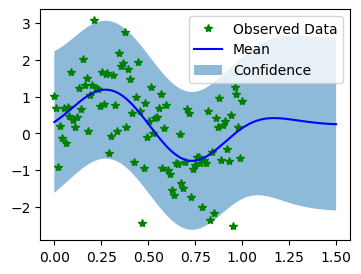

In [6]:
# evaluation step --> returns p(f* | x*, X, y)
# model(test_x) returns model distribution
# likelihood(model(test_x)) returns output distribution
model.eval()
likelihood.eval()

f, ax = plt.subplots(1, 1, figsize=(4, 3))

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    test_x = torch.linspace(0, 1.5, 202)
    observed_pred = likelihood(model(test_x))

    lower, upper = observed_pred.confidence_region()
    ax.plot(train_x.numpy(), train_y.numpy(), 'g*')
    ax.plot(test_x.numpy(), observed_pred.mean.numpy(), 'b')
    ax.fill_between(test_x.numpy(), lower.numpy(), upper.numpy(), alpha=0.5)
    ax.legend(['Observed Data', 'Mean', 'Confidence'])

    plt.show()

In [7]:
for param_name, param in model.named_parameters():
    print("Parameter name:{}, value:{}".format(param_name, param.item()))

Parameter name:likelihood.noise_covar.raw_noise, value:0.2855801582336426
Parameter name:mean_module.raw_constant, value:0.22760523855686188
Parameter name:covar_module.raw_outputscale, value:-0.34951719641685486
Parameter name:covar_module.base_kernel.raw_lengthscale, value:-1.4905515909194946


In [8]:
raw_outputscale = model.covar_module.raw_outputscale

In [9]:
print("raw_outputscale is {}".format(raw_outputscale))

raw_outputscale is -0.34951719641685486


In [10]:
for constraint_name, constraint in model.named_constraints():
    print("Constraint name:{}, constraint:{}".format(constraint_name, constraint))

Constraint name:likelihood.noise_covar.raw_noise_constraint, constraint:GreaterThan(1.000E-04)
Constraint name:covar_module.raw_outputscale_constraint, constraint:Positive()
Constraint name:covar_module.base_kernel.raw_lengthscale_constraint, constraint:Positive()


In [11]:
x = torch.randn(10, 5)
base_covar_module = gpytorch.kernels.RBFKernel()
scaled_covar_module = gpytorch.kernels.ScaleKernel(base_covar_module)
covar = scaled_covar_module(x)
print(x)

tensor([[ 1.1830, -0.5163, -2.7142,  2.1767,  0.4109],
        [ 1.5782, -1.1929,  1.1387,  0.6840,  0.0924],
        [-1.0298, -0.7156,  1.8305, -0.1187,  1.1646],
        [ 0.4917, -0.1458,  0.1094, -2.6317, -0.9869],
        [ 1.7040,  0.3357, -1.4916,  1.4486, -1.1463],
        [-1.4944,  0.7215, -0.4810,  0.5126, -0.8765],
        [ 0.9588, -1.4129, -0.2664,  0.6202,  0.1003],
        [ 0.2536,  1.5716, -0.3132,  0.8393, -2.2713],
        [ 0.2524, -1.4520,  1.5607,  1.1594,  2.2901],
        [ 1.1843,  0.6755,  0.4887, -0.7690,  1.2698]])


In [12]:
s_orig = covar.numpy()
orig = base_covar_module(x).numpy()
print(s_orig[1][0]/orig[1][0])

0.6931472


In [13]:
print(scaled_covar_module.raw_outputscale)
constraint = scaled_covar_module.raw_outputscale_constraint

print('Transformed outputscale', constraint.transform(scaled_covar_module.raw_outputscale))
print('constraint', constraint)
print('Actual outputscale', scaled_covar_module.outputscale)

Parameter containing:
tensor(0., requires_grad=True)
Transformed outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)
constraint Positive()
Actual outputscale tensor(0.6931, grad_fn=<SoftplusBackward0>)


In [14]:
print(likelihood.noise_covar.raw_noise)
print(likelihood.noise)

Parameter containing:
tensor([0.2856], requires_grad=True)
tensor([0.8462], grad_fn=<AddBackward0>)
